<p><font size="6"><b> CASE - Observation data - data cleaning and enrichment</b></font></p>

> *© 2025, Joris Van den Bossche and Stijn Van Hoey  (<mailto:jorisvandenbossche@gmail.com>, <mailto:stijnvanhoey@gmail.com>). Licensed under [CC BY 4.0 Creative Commons](http://creativecommons.org/licenses/by/4.0/)*

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')

**Scenario**:<br>

Observation data of species (when and where is a given species observed) is typical in biodiversity studies. Large international initiatives support the collection of this data by volunteers, e.g. [iNaturalist](https://www.inaturalist.org/). Thanks to initiatives like [GBIF](https://www.gbif.org/), a lot of these data is also openly available.

You decide to share data of a field campaign, but the data set still requires some cleaning and standardization. For example, the coordinates, can be named `x`/`y`, `decimalLatitude`/`decimalLongitude`, `lat`/`long`... Luckily, you know of an international **open data standard** to describe occurrence/observation data, i.e. [Darwin Core (DwC)](http://rs.tdwg.org/dwc/terms). Instead of inventing your own data model, you decide to comply to this international standard. The latter will enhance communication and will also make your data compliant with GBIF.

In short, the DwC describes a flat table (cfr. `CSV`) with an agreed name convention on the header names and conventions on how certain data types need to be represented (as a reference, an in depth description is given [here](https://www.tdwg.org/standards/dwc/)). For this tutorial, we will focus on a few of the existing terms to learn some elements about data cleaning:
* `eventDate`: ISO 6801 format of dates
* `scientificName`: the accepted scientific name of the species
* `decimalLatitude`/`decimalLongitude`: coordinates of the occurrence in WGS84 format
* `sex`: either `male` or `female` to characterize the sex of the occurrence
* `occurrenceID`: an identifier within the data set to identify the individual records
* `datasetName`: a static string defining the source of the data

Furthermore, additional information concerning the taxonomy will be added using an external API service

**Dataset to work on:**

For this data set, the data is split up in the following main data files:
* `surveys.csv` the data with the surveys in the individual plots
* `species.csv` the overview list of the species short-names
* `plot_location.xlsx` the overview of coordinates of the individual locations

The data originates from a [study](http://esapubs.org/archive/ecol/E090/118/metadata.htm) of a Chihuahuan desert ecosystem near Portal, Arizona.

![](../img/plot_overview.png)

## 1. Survey-data

Reading in the data of the individual surveys:

In [2]:
survey_data = pd.read_csv("data/surveys.csv")

In [3]:
survey_data.head()

,record_id,month,day,year,plot,species,sex_char,wgt
0,1,7,16,1977,2,NaN,M,NaN
1,2,7,16,1977,3,NaN,M,NaN
2,3,7,16,1977,2,DM,F,NaN
3,4,7,16,1977,7,DM,M,NaN
4,5,7,16,1977,3,DM,M,NaN


<div class="alert alert-success">

**EXERCISE**

- How many individual records (occurrences) does the survey data set contain?

</div>

In [4]:
len(survey_data)

35549

### Adding the data source information as static column

For convenience when this data-set will be combined with other datasets, we first add a column of static values, defining the `datasetName` of this particular data:

In [5]:
datasetname = "Ecological Archives E090-118-D1."

Adding this static value as a new column `datasetName`:

<div class="alert alert-success">

**EXERCISE**

Add a new column, `datasetName`, to the survey data set with `datasetname` as value for all of the records (static value for the entire data set)

<details><summary>Hints</summary>

- When a column does not exist, a new `df["a_new_column"]` can be created by assigning a value to it.
- No `for`-loop is required, as Pandas will automatically broadcast a single string value to each of the rows in the `DataFrame`.

</details>

</div>

In [6]:
survey_data["datasetName"] = datasetname

### Cleaning the `sex_char` column into a DwC called [sex](http://rs.tdwg.org/dwc/terms/#sex) column

<div class="alert alert-success">

**EXERCISE**

- Get a list of the unique values for the column `sex_char`.

<details><summary>Hints</summary>

- To find the unique values, look for a function called `unique` (remember `SHIFT`+`TAB` combination to explore the available methods/attributes?)

</details>

</div>

In [7]:
survey_data["sex_char"].unique().tolist()

['M', 'F', nan, 'R', 'P', 'Z']

So, apparently, more information is provided in this column, whereas according to the [metadata](http://esapubs.org/archive/ecol/E090/118/Portal_rodent_metadata.htm) information, the sex information should be either `M` (male) or `F` (female). We will create a column, named `sex` and convert the symbols to the corresponding sex, taking into account the following mapping of the values (see [metadata](http://esapubs.org/archive/ecol/E090/118/Portal_rodent_metadata.htm) for more details):
* `M` -> `male`
* `F` -> `female`
* `R` -> `male`
* `P` -> `female`
* `Z` -> nan

At the same time, we will save the original information of the `sex_char` in a separate column, called `verbatimSex`, as a reference in case we need the original data later.

In summary, we have to:
* rename the `sex_char` column to `verbatimSex`
* create a new column with the name `sex`
* map the original values of the `sex_char` to the values `male` and `female` according to the mapping above

First, let's convert the name of the column header `sex_char` to `verbatimSex` with the `rename` function:

In [8]:
survey_data = survey_data.rename(columns={'sex_char': 'verbatimSex'})

<div class="alert alert-success">

**EXERCISE**

- Express the mapping of the values (e.g. `M` -> `male`) into a Python dictionary object with the variable name `sex_dict`. `Z` values correspond to _Not a Number_, which can be defined as `np.nan`.
- Use the `sex_dict` dictionary to replace the values in the `verbatimSex` column to the new values and save the mapped values in a new column 'sex' of the DataFrame.

<details><summary>Hints</summary>

- A dictionary is a Python standard library data structure, see https://docs.python.org/3/tutorial/datastructures.html#dictionaries - no Pandas magic involved when you need a key/value mapping.
- When you need to replace values, look for the Pandas method `replace`.

</details>

</div>

In [9]:
sex_dict = {"M": "male",
            "F": "female",
            "R": "male",
            "P": "female",
            "Z": np.nan}

In [10]:
survey_data['sex'] = survey_data['verbatimSex'].replace(sex_dict)

Checking the current frequency of values of the resulting `sex` column (this should result in the values `male`, `female` and `nan`):

In [11]:
survey_data["sex"].unique()

array(['male', 'female', nan], dtype=object)

To check what the frequency of occurrences is for male/female of the categories, a bar chart is a possible representation:

<div class="alert alert-success">

**EXERCISE**

- Make a horizontal bar chart comparing the number of male, female and unknown (`NaN`) records in the data set.

<details><summary>Hints</summary>

- Pandas provides a shortcut method `value_counts` which works on Pandas `Series` to count unique values. Explore the documentation of the `value_counts` method to include the `NaN` values as well.
- Check in the help of the Pandas plot function for the `kind` parameter.

</details>

</div>

<Axes: ylabel='sex'>

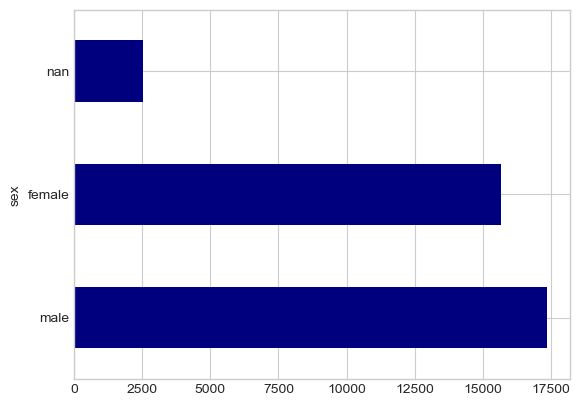

In [12]:
survey_data["sex"].value_counts(dropna=False).plot(kind="barh", color="#00007f")

<div class="alert alert-warning">

<b>NOTE</b>: The usage of `groupby` combined with the `size` of each group would be an option as well. However, the latter does not support to count the `NaN` values as well. The `value_counts` method does support this with the `dropna=False` argument.

</div>

### Solving double entry field by decoupling

When checking the species unique information:

In [13]:
survey_data["species"].unique()

array([nan, 'DM', 'PF', 'PE', 'DM and SH', 'DS', 'PP', 'SH', 'OT', 'DO',
       'OX', 'SS', 'OL', 'RM', 'SA', 'PM', 'AH', 'DX', 'AB', 'CB', 'CM',
       'CQ', 'RF', 'PC', 'PG', 'PH', 'PU', 'CV', 'UR', 'UP', 'ZL', 'UL',
       'CS', 'SC', 'BA', 'SF', 'RO', 'AS', 'SO', 'PI', 'ST', 'CU', 'SU',
       'RX', 'PB', 'PL', 'PX', 'CT', 'US'], dtype=object)

In [14]:
survey_data.head(10)

,record_id,month,day,year,plot,species,verbatimSex,wgt,datasetName,sex
0,1,7,16,1977,2,NaN,M,NaN,Ecological Archives E090-118-D1.,male
1,2,7,16,1977,3,NaN,M,NaN,Ecological Archives E090-118-D1.,male
2,3,7,16,1977,2,DM,F,NaN,Ecological Archives E090-118-D1.,female
3,4,7,16,1977,7,DM,M,NaN,Ecological Archives E090-118-D1.,male
4,5,7,16,1977,3,DM,M,NaN,Ecological Archives E090-118-D1.,male
5,6,7,16,1977,1,PF,M,NaN,Ecological Archives E090-118-D1.,male
6,7,7,16,1977,2,PE,F,NaN,Ecological Archives E090-118-D1.,female
7,8,7,16,1977,1,DM,M,NaN,Ecological Archives E090-118-D1.,male
8,9,7,16,1977,1,DM and SH,NaN,NaN,Ecological Archives E090-118-D1.,NaN
9,10,7,16,1977,6,PF,F,NaN,Ecological Archives E090-118-D1.,female


There apparently exists a double entry: `'DM and SH'`, which basically defines two records and should be decoupled to two individual records (i.e. rows). Hence, we should be able to create an additional row based on this split. To do so, Pandas provides a dedicated function since version 0.25, called `explode`. Starting from a small subset example:

In [15]:
example = survey_data.loc[7:10, "species"]
example

7            DM
8     DM and SH
9            PF
10           DS
Name: species, dtype: object

Using the `split` method on strings, we can split the string using a given character, in this case the word `and`:

In [16]:
example.str.split("and")

7           [DM]
8     [DM ,  SH]
9           [PF]
10          [DS]
Name: species, dtype: object

The `explode` method will create a row for each element in the list:

In [17]:
example_split = example.str.split("and").explode()
example_split

7      DM
8     DM 
8      SH
9      PF
10     DS
Name: species, dtype: object

Hence, the `DM` and `SH` are now enlisted in separate rows. Other rows remain unchanged. The only remaining issue is the spaces around the characters:

In [18]:
example_split.iloc[1], example_split.iloc[2]

('DM ', ' SH')

Which we can solve again using the string method `strip`, removing the spaces before and after the characters:

In [19]:
example_split.str.strip()

7     DM
8     DM
8     SH
9     PF
10    DS
Name: species, dtype: object

To make this reusable, let's create a dedicated function to combine these steps, called `solve_double_field_entry`:

In [20]:
def solve_double_field_entry(df, keyword="and", column="verbatimEventDate"):
    """Split on keyword in column for an enumeration and create extra record

    Parameters
    ----------
    df: pd.DataFrame
        DataFrame with a double field entry in one or more values
    keyword: str
        word/character to split the double records on
    column: str
        column name to use for the decoupling of the records
    """
    df = df.copy()  # copy the input DataFrame to avoid editing the original
    df[column] = df[column].str.split(keyword)
    df = df.explode(column)
    df[column] = df[column].str.strip()  # remove white space around the words
    return df

The function takes a `DataFrame` as input, splits the record into separate rows and returns an updated `DataFrame`. We can use this function to get an update of the `DataFrame`, with an additional row (observation) added by decoupling the specific field. Let's apply this new function.

<div class="alert alert-success">

**EXERCISE**

- Use the function `solve_double_field_entry` to update the `survey_data` by decoupling the double entries. Save the result as a variable `survey_data_decoupled`.

<details><summary>Hints</summary>

- As we added a 'docstring' to the function, we can check our own documentation to know how to use the function and which inputs we should provide. You can use `SHIFT` + `TAB` to explore the documentation just like any other function.

</details>

</div>

In [21]:
survey_data_decoupled = solve_double_field_entry(survey_data,
                                                 "and",
                                                 column="species") # get help of the function by SHIFT + TAB

In [22]:
survey_data_decoupled["species"].unique()

array([nan, 'DM', 'PF', 'PE', 'SH', 'DS', 'PP', 'OT', 'DO', 'OX', 'SS',
       'OL', 'RM', 'SA', 'PM', 'AH', 'DX', 'AB', 'CB', 'CM', 'CQ', 'RF',
       'PC', 'PG', 'PH', 'PU', 'CV', 'UR', 'UP', 'ZL', 'UL', 'CS', 'SC',
       'BA', 'SF', 'RO', 'AS', 'SO', 'PI', 'ST', 'CU', 'SU', 'RX', 'PB',
       'PL', 'PX', 'CT', 'US'], dtype=object)

In [23]:
survey_data_decoupled.head(11)

,record_id,month,day,year,plot,species,verbatimSex,wgt,datasetName,sex
0,1,7,16,1977,2,NaN,M,NaN,Ecological Archives E090-118-D1.,male
1,2,7,16,1977,3,NaN,M,NaN,Ecological Archives E090-118-D1.,male
2,3,7,16,1977,2,DM,F,NaN,Ecological Archives E090-118-D1.,female
3,4,7,16,1977,7,DM,M,NaN,Ecological Archives E090-118-D1.,male
4,5,7,16,1977,3,DM,M,NaN,Ecological Archives E090-118-D1.,male
5,6,7,16,1977,1,PF,M,NaN,Ecological Archives E090-118-D1.,male
6,7,7,16,1977,2,PE,F,NaN,Ecological Archives E090-118-D1.,female
7,8,7,16,1977,1,DM,M,NaN,Ecological Archives E090-118-D1.,male
8,9,7,16,1977,1,DM,NaN,NaN,Ecological Archives E090-118-D1.,NaN
8,9,7,16,1977,1,SH,NaN,NaN,Ecological Archives E090-118-D1.,NaN


### Create new occurrence identifier

The `record_id` is no longer a unique identifier for each observation after the decoupling of this data set. We will make a new data set specific identifier, by adding a column called `occurrenceID` that takes a new counter as identifier. As a simple and straightforward approach, we will use a new counter for the whole dataset, starting with 1:

In [24]:
np.arange(1, len(survey_data_decoupled) + 1, 1)

array([    1,     2,     3, ..., 35548, 35549, 35550], shape=(35550,))

To create a new column with header `occurrenceID` with the values 1 -> 35550 as field values:

In [25]:
survey_data_decoupled["occurrenceID"] = np.arange(1, len(survey_data_decoupled) + 1, 1)

To overcome the confusion on having both a `record_id` and `occurrenceID` field, we will remove the `record_id` term:

In [26]:
survey_data_decoupled = survey_data_decoupled.drop(columns="record_id")

Hence, columns can be `drop`-ped out of a DataFrame

In [27]:
survey_data_decoupled.head(10)

,month,day,year,plot,species,verbatimSex,wgt,datasetName,sex,occurrenceID
0,7,16,1977,2,NaN,M,NaN,Ecological Archives E090-118-D1.,male,1
1,7,16,1977,3,NaN,M,NaN,Ecological Archives E090-118-D1.,male,2
2,7,16,1977,2,DM,F,NaN,Ecological Archives E090-118-D1.,female,3
3,7,16,1977,7,DM,M,NaN,Ecological Archives E090-118-D1.,male,4
4,7,16,1977,3,DM,M,NaN,Ecological Archives E090-118-D1.,male,5
5,7,16,1977,1,PF,M,NaN,Ecological Archives E090-118-D1.,male,6
6,7,16,1977,2,PE,F,NaN,Ecological Archives E090-118-D1.,female,7
7,7,16,1977,1,DM,M,NaN,Ecological Archives E090-118-D1.,male,8
8,7,16,1977,1,DM,NaN,NaN,Ecological Archives E090-118-D1.,NaN,9
8,7,16,1977,1,SH,NaN,NaN,Ecological Archives E090-118-D1.,NaN,10


### Converting the date values

In the survey data set we received, the `month`, `day`, and `year` columns are containing the information about the date, i.e. `eventDate` in DarwinCore terms. We want this data in a ISO format `YYYY-MM-DD`. A convenient Pandas function is the usage of `to_datetime`, which provides multiple options to interpret dates. One of the options is the automatic interpretation of some 'typical' columns, like `year`, `month` and `day`, when passing a `DataFrame`.

In [28]:
# pd.to_datetime(survey_data_decoupled[["year", "month", "day"]])  # uncomment the line and test this statement

This is not working, not all dates can be interpreted... We should get some more information on the reason of the errors. By using the option `coerce`, the problem makers will be labeled as a missing value `NaT`. We can count the number of dates that can not be interpreted:

In [29]:
sum(pd.to_datetime(survey_data_decoupled[["year", "month", "day"]], errors='coerce').isna())

136

<div class="alert alert-success">

**EXERCISE**

- Make a selection of `survey_data_decoupled` containing those records that can not correctly be interpreted as date values and save the resulting `DataFrame` as a new variable `trouble_makers`

<details><summary>Hints</summary>

- The result of the `.isna()` method is a `Series` of boolean values, which can be used to make a selection (so called boolean indexing or filtering)

</details>

</div>

In [30]:
mask = pd.to_datetime(survey_data_decoupled[["year", "month", "day"]], errors='coerce').isna()
trouble_makers = survey_data_decoupled[mask]

Checking some charactersitics of the trouble_makers:

In [31]:
trouble_makers.head()

,month,day,year,plot,species,verbatimSex,wgt,datasetName,sex,occurrenceID
30649,4,31,2000,6,PP,F,19.0,Ecological Archives E090-118-D1.,female,30651
30650,4,31,2000,6,PB,M,32.0,Ecological Archives E090-118-D1.,male,30652
30651,4,31,2000,6,PB,F,30.0,Ecological Archives E090-118-D1.,female,30653
30652,4,31,2000,6,PP,M,20.0,Ecological Archives E090-118-D1.,male,30654
30653,4,31,2000,6,PP,M,24.0,Ecological Archives E090-118-D1.,male,30655


In [32]:
trouble_makers["day"].unique()

array([31])

In [33]:
trouble_makers["month"].unique()

array([4, 9])

In [34]:
trouble_makers["year"].unique()

array([2000])

The issue is the presence of day `31` during the months April and September of the year 2000. At this moment, we would have to recheck the original data in order to know how the issue could be solved. Apparently, - for this specific case - there has been a data-entry problem in 2000, making the `31` days during this period should actually be `30`. It would be optimal to correct this in the source data set, but for the exercise, we will correct it here.

<div class="alert alert-success">

**EXERCISE**

- Assign in the `DataFrame` `survey_data_decoupled` all of the troublemakers `day` values the value 30 instead of 31.

<details><summary>Hints</summary>

- No `for`-loop is required, but use the same boolean mask to assign the new value to the correct rows.
- Check `pandas_03b_indexing.ipynb` for the usage of `loc` and `iloc` to assign new values.
- With `loc`, specify both the selecting for the rows and for the columns (`df.loc[row_indexer, column_indexer] = ..`).

</details>

</div>

In [35]:
mask = pd.to_datetime(survey_data_decoupled[["year", "month", "day"]], errors='coerce').isna()
survey_data_decoupled.loc[mask, "day"] = 30

Now, we do the parsing again to create a proper `eventDate` field, containing the dates:

In [36]:
survey_data_decoupled["eventDate"] = \
    pd.to_datetime(survey_data_decoupled[["year", "month", "day"]])

<div class="alert alert-success">

**EXERCISE**

- Check the number of observations for each year. Create a horizontal bar chart with the number of rows/observations for each year.

<details><summary>Hints</summary>

- To get the total number of observations, both the usage of `value_counts` as using `groupby` + `size` will work.  `value_counts` is a convenient function when all you need to do is counting rows.
- When using `value_counts`, the years in the index will no longer be in ascending order. You can chain methods and include a `sort_index()` method to sort these again.

</details>


</div>

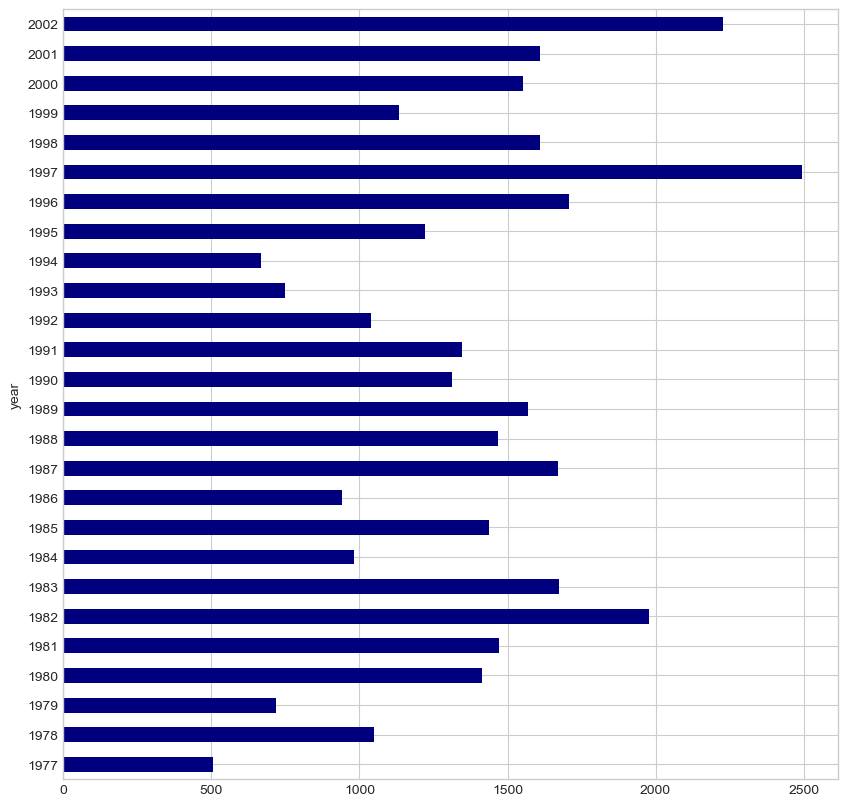

In [37]:
(survey_data_decoupled["year"]
     .value_counts(sort=False)
     .sort_index()
     .plot(kind='barh', color="#00007f", figsize=(10, 10)));

<Axes: ylabel='year'>

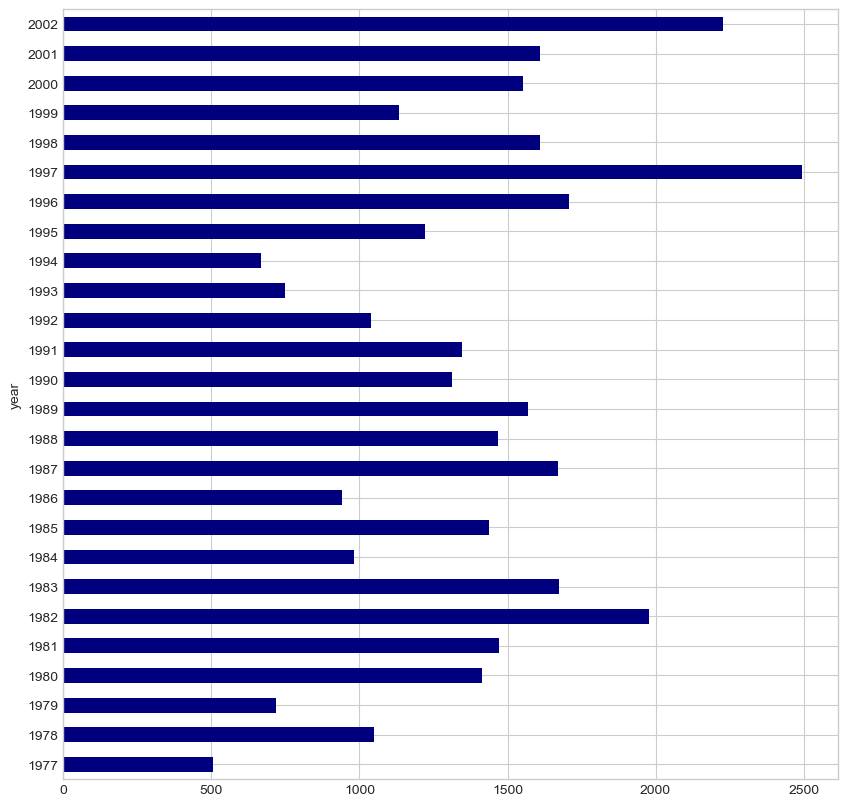

In [38]:
(survey_data_decoupled
     .groupby("year")
     .size()
     .plot(kind='barh', color="#00007f", figsize=(10, 10)))

In [39]:
survey_data_decoupled.head()

,month,day,year,plot,species,verbatimSex,wgt,datasetName,sex,occurrenceID,eventDate
0,7,16,1977,2,NaN,M,NaN,Ecological Archives E090-118-D1.,male,1,1977-07-16
1,7,16,1977,3,NaN,M,NaN,Ecological Archives E090-118-D1.,male,2,1977-07-16
2,7,16,1977,2,DM,F,NaN,Ecological Archives E090-118-D1.,female,3,1977-07-16
3,7,16,1977,7,DM,M,NaN,Ecological Archives E090-118-D1.,male,4,1977-07-16
4,7,16,1977,3,DM,M,NaN,Ecological Archives E090-118-D1.,male,5,1977-07-16


Currently, the dates are stored in a python specific date format:

In [40]:
survey_data_decoupled["eventDate"].dtype

dtype('<M8[ns]')

This is great, because it allows for many functionalities using the `.dt` accessor:

In [41]:
survey_data_decoupled.eventDate.dt #add a dot (.) and press TAB to explore the date options it provides

<div class="alert alert-success">

**EXERCISE**

- Create a horizontal bar chart with the number of records for each year (cfr. supra), but without using the column `year`, using the `eventDate` column directly.

<details><summary>Hints</summary>

- Check the `groupby` + `size` solution of the previous exercise and use this to start with. Replace the `year` inside the `groupby` method...

</details>

</div>

<Axes: ylabel='eventDate'>

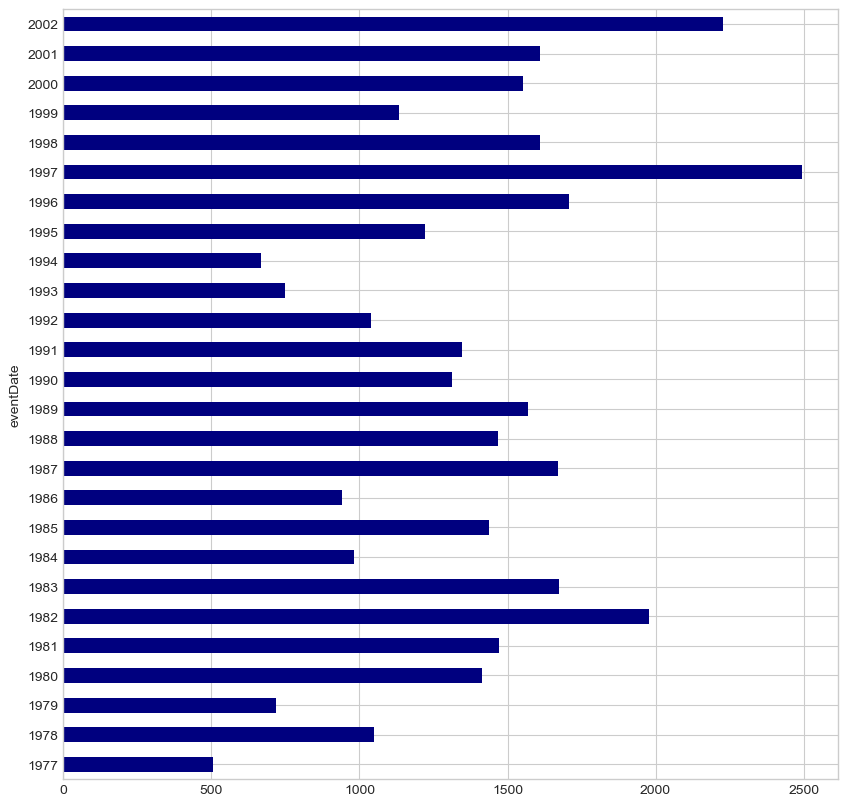

In [42]:
(survey_data_decoupled
     .groupby(survey_data_decoupled["eventDate"].dt.year)
     .size()
     .plot(kind='barh', color="#00007f", figsize=(10, 10)))

We actually do not need the `day`, `month`, `year` columns anymore, but feel free to use what suits you best.

<div class="alert alert-success">

**EXERCISE**

- Create a bar chart with the number of records for each day of the week (`dayofweek`)

<details><summary>Hints</summary>

- Pandas has an accessor for `dayofweek` as well.
- You can specify the days of the week yourself to improve the plot, or use the Python standard library `calendar.day_name` (import the calendar module first) to get the names.

</details>

</div>

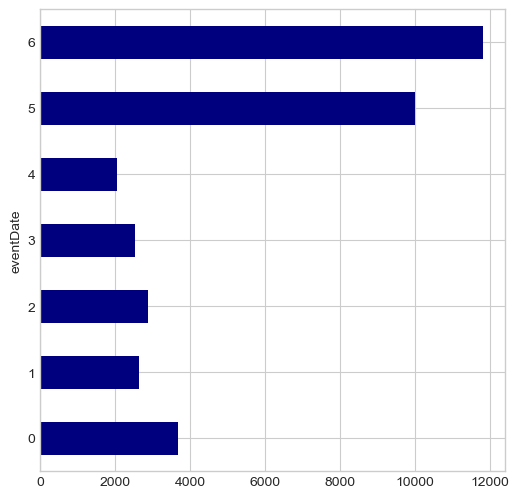

In [43]:
nrecords_by_dayofweek = survey_data_decoupled["eventDate"].dt.dayofweek.value_counts().sort_index()

fig, ax = plt.subplots(figsize=(6, 6))
nrecords_by_dayofweek.plot(kind="barh", color="#00007f", ax=ax);
# If you want to represent the ticklabels as proper names, uncomment the following line:
# ax.set_yticklabels(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]);

# Python standard library has a lot of useful functionalities! So why not use them?
#import calendar
#ax.set_yticklabels(calendar.day_name);

When saving the information to a file (e.g. `CSV`-file), this data type will be automatically converted to a string representation. However, we could also decide to explicitly provide the string format the dates are stored (losing the date type functionalities), in order to have full control on the way these dates are formatted:

In [44]:
survey_data_decoupled["eventDate"] = survey_data_decoupled["eventDate"].dt.strftime('%Y-%m-%d')

In [45]:
survey_data_decoupled["eventDate"].head()

0    1977-07-16
1    1977-07-16
2    1977-07-16
3    1977-07-16
4    1977-07-16
Name: eventDate, dtype: object

For the remainder, let's remove the day/year/month columns.

In [46]:
survey_data_decoupled = survey_data_decoupled.drop(columns=["day", "month", "year"])

## 2. Add species names to dataset

The column `species` only provides a short identifier in the survey overview. The name information is stored in a separate file `species.csv`. We want our data set to include this information, read in the data and add it to our survey data set:

<div class="alert alert-success">

**EXERCISE**

- Read in the 'species.csv' file and save the resulting `DataFrame` as variable `species_data`.

<details><summary>Hints</summary>

- Check the delimiter (`sep`) parameter of the `read_csv` function.

</details>

</div>

In [47]:
species_data = pd.read_csv("data/species.csv", sep=";")

In [48]:
species_data.head()

,species_id,genus,species,taxa
0,AB,Amphispiza,bilineata,Bird
1,AH,Ammospermophilus,harrisi,Rodent-not censused
2,AS,Ammodramus,savannarum,Bird
3,BA,Baiomys,taylori,Rodent
4,CB,Campylorhynchus,brunneicapillus,Bird


### Fix a wrong acronym naming

When reviewing the metadata, you see that in the data-file the acronym `NE` is used to describe `Neotoma albigula`, whereas in the [metadata description](http://esapubs.org/archive/ecol/E090/118/Portal_rodent_metadata.htm), the acronym `NA` is used.

<div class="alert alert-success">

**EXERCISE**

- Convert the value of 'NE' to 'NA' by using Boolean indexing/Filtering for the `species_id` column.

<details><summary>Hints</summary>

- To assign a new value, use the `loc` operator.
- With `loc`, specify both the selecting for the rows and for the columns (`df.loc[row_indexer, column_indexer] = ..`).

</details>

</div>

In [49]:
species_data.loc[species_data["species_id"] == "NE", "species_id"] = "NA"

# note: for such a 1:1 replacement, we could also use the "replace()" method
# species_data["species_id"] = species_data["species_id"].replace({"NE": "NA"})

### Merging surveys and species

As we now prepared the two series, we can combine the data, using again the `pd.merge` operation.

We want to add the data of the species to the survey data, in order to see the full species names in the combined data table.

<div class="alert alert-success">

**EXERCISE**

Combine the DataFrames `survey_data_decoupled` and `species_data` by adding the corresponding species information (name, class, kingdom,..) to the individual observations. Assign the output to a new variable `survey_data_species`.

<details><summary>Hints</summary>

- This is an example of a database JOIN operation. Pandas provides the `pd.merge` function to join two data sets using a common identifier.
- Take into account that our key-column is different for `species_data` and `survey_data_decoupled`, respectively `species` and `species_id`. The `pd.merge()` function has `left_on` and `right_on` keywords to specify the name of the column in the left and right `DataFrame` to merge on.

</details>

In [50]:
survey_data_species = pd.merge(survey_data_decoupled, species_data, how="left",  # LEFT OR INNER?
                                left_on="species", right_on="species_id")

In [51]:
len(survey_data_species) # check length after join operation

35550

The join is ok, but we are left with some redundant columns and wrong naming:

In [52]:
survey_data_species.head()

,plot,species_x,verbatimSex,wgt,datasetName,sex,occurrenceID,eventDate,species_id,genus,species_y,taxa
0,2,NaN,M,NaN,Ecological Archives E090-118-D1.,male,1,1977-07-16,NaN,NaN,NaN,NaN
1,3,NaN,M,NaN,Ecological Archives E090-118-D1.,male,2,1977-07-16,NaN,NaN,NaN,NaN
2,2,DM,F,NaN,Ecological Archives E090-118-D1.,female,3,1977-07-16,DM,Dipodomys,merriami,Rodent
3,7,DM,M,NaN,Ecological Archives E090-118-D1.,male,4,1977-07-16,DM,Dipodomys,merriami,Rodent
4,3,DM,M,NaN,Ecological Archives E090-118-D1.,male,5,1977-07-16,DM,Dipodomys,merriami,Rodent


We do not need the columns `species_x` and `species_id` column anymore, as we will use the scientific names from now on:

In [53]:
survey_data_species = survey_data_species.drop(["species_x", "species_id"], axis=1)

The column `species_y` could just be named `species`:

In [54]:
survey_data_species = survey_data_species.rename(columns={"species_y": "species"})

In [55]:
survey_data_species.head()

,plot,verbatimSex,wgt,datasetName,sex,occurrenceID,eventDate,genus,species,taxa
0,2,M,NaN,Ecological Archives E090-118-D1.,male,1,1977-07-16,NaN,NaN,NaN
1,3,M,NaN,Ecological Archives E090-118-D1.,male,2,1977-07-16,NaN,NaN,NaN
2,2,F,NaN,Ecological Archives E090-118-D1.,female,3,1977-07-16,Dipodomys,merriami,Rodent
3,7,M,NaN,Ecological Archives E090-118-D1.,male,4,1977-07-16,Dipodomys,merriami,Rodent
4,3,M,NaN,Ecological Archives E090-118-D1.,male,5,1977-07-16,Dipodomys,merriami,Rodent


In [56]:
len(survey_data_species)

35550

## 3. Add coordinates from the plot locations

### Loading the coordinate data

The individual plots are only identified by a `plot` identification number. In order to provide sufficient information to external users, additional information about the coordinates should be added. The coordinates of the individual plots are saved in another file: `plot_location.xlsx`. We will use this information to further enrich our data set and add the Darwin Core Terms `decimalLongitude` and `decimalLatitude`.

<div class="alert alert-success">

**EXERCISE**

- Read the excel file 'plot_location.xlsx' and store the data as the variable `plot_data`, with 3 columns: plot, xutm, yutm.

<details><summary>Hints</summary>

- Pandas read methods all have a similar name, `read_...`.

</details>

</div>

In [57]:
plot_data = pd.read_excel("data/plot_location.xlsx", skiprows=3, index_col=0)

In [58]:
plot_data.head()

,plot,xutm,yutm
0,1,681222.131658,3.535262e+06
1,2,681302.799361,3.535268e+06
2,3,681375.294968,3.535270e+06
3,4,681450.837525,3.535271e+06
4,5,681526.983040,3.535281e+06


### Transforming to other coordinate reference system

These coordinates are in meters, more specifically in the [UTM 12 N](https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system) coordinate system. However, the agreed coordinate representation for Darwin Core is the [World Geodetic System 1984 (WGS84)](http://spatialreference.org/ref/epsg/wgs-84/).

As this is not a GIS course, we will shortcut the discussion about different projection systems, but provide an example on how such a conversion from `UTM12N` to `WGS84` can be performed with the projection toolkit `pyproj` and by relying on the existing EPSG codes (a registry originally setup by the association of oil & gas producers).

First, we define out two projection systems, using their corresponding EPSG codes:

In [59]:
from pyproj import Transformer

In [60]:
transformer = Transformer.from_crs("EPSG:32612", "epsg:4326")

The reprojection can be done by the function `transform` of the projection toolkit, providing the coordinate systems and a set of x, y coordinates. For example, for a single coordinate, this can be applied as follows:

In [61]:
transformer.transform(681222.131658, 3.535262e+06)

(31.9388498837225, -109.08282902317859)

Such a transformation is a function not supported by Pandas itself (it is in https://geopandas.org/). In such an situation, we want to _apply_ a custom function to _each row of the DataFrame_. Instead of writing a `for` loop to do this for each of the coordinates in the list, we can `.apply()` this function with Pandas.

<div class="alert alert-success">

**EXERCISE**

Apply the pyproj function `transform` to plot_data, using the columns `xutm` and `yutm` and save the resulting output in 2 new columns, called `decimalLongitude` and `decimalLatitude`:

- Create a function `transform_utm_to_wgs` that takes a row of a `DataFrame` and returns a `Series` of two elements with the longitude and latitude.
- Test this function on the first row of `plot_data`
- Now `apply` this function on all rows (use the `axis` parameter correct)
- Assign the result of the previous step to `decimalLongitude` and `decimalLatitude` columns

<details><summary>Hints</summary>

- Convert the output of the transformer to a Series before returning (`pd.Series(....)`)
- A convenient way to select a single row is using the `.loc[0]` operator.
- `apply` can be used for both rows (`axis` 1) as columns (`axis` 0).
- To assign two columns at once, you can use a similar syntax as for selecting multiple columns with a list of column names (`df[['col1', 'col2']]`).

</details>

</div>

In [62]:
def transform_utm_to_wgs(row):
    """Converts the x and y coordinates

    Parameters
    ----------
    row : pd.Series
        Single DataFrame row

    Returns
    -------
    pd.Series with longitude and latitude
    """
    transformer = Transformer.from_crs("EPSG:32612", "epsg:4326")

    return pd.Series(transformer.transform(row['xutm'], row['yutm']))

In [63]:
# test the new function on a single row of the DataFrame
transform_utm_to_wgs(plot_data.loc[0])

0     31.938851
1   -109.082829
dtype: float64

In [64]:
plot_data.apply(transform_utm_to_wgs, axis=1)

,0,1
0,31.938851,-109.082829
1,31.938887,-109.081975
2,31.938896,-109.081208
3,31.938894,-109.080409
4,31.938970,-109.079602
5,31.939078,-109.078836
6,31.938113,-109.082816
7,31.937884,-109.081680
8,31.937859,-109.080903
9,31.938017,-109.080091


In [65]:
plot_data[["decimalLongitude" ,"decimalLatitude"]] = plot_data.apply(transform_utm_to_wgs, axis=1)

In [66]:
plot_data.head()

,plot,xutm,yutm,decimalLongitude,decimalLatitude
0,1,681222.131658,3.535262e+06,31.938851,-109.082829
1,2,681302.799361,3.535268e+06,31.938887,-109.081975
2,3,681375.294968,3.535270e+06,31.938896,-109.081208
3,4,681450.837525,3.535271e+06,31.938894,-109.080409
4,5,681526.983040,3.535281e+06,31.938970,-109.079602


The above function `transform_utm_to_wgs` you have created is a very specific function that knows the structure of the `DataFrame` you will apply it to (it assumes the 'xutm' and 'yutm' column names). We could also make a more generic function that just takes a X and Y coordinate and returns the `Series` of converted coordinates (`transform_utm_to_wgs2(X, Y)`).

An alternative to apply such a custom function to the `plot_data` `DataFrame` is the usage of the `lambda` construct, which lets you specify a function on one line as an argument:

    transformer = Transformer.from_crs("EPSG:32612", "epsg:4326")
    plot_data.apply(lambda row : transformer.transform(row['xutm'], row['yutm']), axis=1)


<div class="alert alert-warning">

__WARNING__

Do not abuse the usage of the `apply` method, but always look for an existing Pandas function first as these are - in general - faster!

</div>

### Join the coordinate information to the survey data set

We can extend our survey data set with this coordinate information. Making the combination of two data sets based on a common identifier is completely similar to the usage of `JOIN` operations in databases. In Pandas, this functionality is provided by [`pd.merge`](http://pandas.pydata.org/pandas-docs/stable/merging.html#database-style-DataFrame-joining-merging).

In practice, we have to add the columns `decimalLongitude`/`decimalLatitude` to the current data set `survey_data_species`, by using the plot identification number as key to join.

<div class="alert alert-success">

**EXERCISE**

- Extract only the columns to join to our survey dataset: the `plot` identifiers, `decimalLatitude` and `decimalLongitude` into a new variable named `plot_data_selection`

<details><summary>Hints</summary>

- To select multiple columns, use a `list` of column names, e.g. `df[["my_col1", "my_col2"]]`

</details>

</div>

In [67]:
plot_data_selection = plot_data[["plot", "decimalLongitude", "decimalLatitude"]]

<div class="alert alert-success">

**EXERCISE**

Combine the DataFrame `plot_data_selection` and the DataFrame `survey_data_species` by adding the corresponding coordinate information to the individual observations using the `pd.merge()` function. Assign the output to a new variable `survey_data_plots`.

<details><summary>Hints</summary>

- This is an example of a database JOIN operation. Pandas provides the `pd.merge` function to join two data sets using a common identifier.
- The key-column is the `plot`.

</details>

In [68]:
survey_data_plots = pd.merge(survey_data_species, plot_data_selection,
                             how="left", on="plot")

In [69]:
survey_data_plots.head()

,plot,verbatimSex,wgt,datasetName,sex,occurrenceID,eventDate,genus,species,taxa,decimalLongitude,decimalLatitude
0,2,M,NaN,Ecological Archives E090-118-D1.,male,1,1977-07-16,NaN,NaN,NaN,31.938887,-109.081975
1,3,M,NaN,Ecological Archives E090-118-D1.,male,2,1977-07-16,NaN,NaN,NaN,31.938896,-109.081208
2,2,F,NaN,Ecological Archives E090-118-D1.,female,3,1977-07-16,Dipodomys,merriami,Rodent,31.938887,-109.081975
3,7,M,NaN,Ecological Archives E090-118-D1.,male,4,1977-07-16,Dipodomys,merriami,Rodent,31.938113,-109.082816
4,3,M,NaN,Ecological Archives E090-118-D1.,male,5,1977-07-16,Dipodomys,merriami,Rodent,31.938896,-109.081208


The plot locations need to be stored with the variable name `verbatimLocality` indicating the identifier as integer value of the plot:

In [70]:
survey_data_plots = survey_data_plots.rename(columns={'plot': 'verbatimLocality'})

Let's now save our clean data to a `csv` file, so we can further analyze the data in a following notebook:

In [71]:
survey_data_plots.to_csv("interim_survey_data_species.csv", index=False)

## (OPTIONAL SECTION) 4. Using a API service to match the scientific names

As the current species names are rather short and could eventually lead to confusion when shared with other users, retrieving additional information about the different species in our dataset would be useful to integrate our work with other research. An option is to match our names with an external service to request additional information about the different species.

One of these services is [GBIF API](http://www.gbif.org/developer/species). The service can most easily be illustrated with a small example:<br><br>
In a new tab blad of the browser, go to the URL [http://www.gbif.org/species/2475532](http://www.gbif.org/species/2475532), which corresponds to the page of `Alcedo atthis` (*ijsvogel* in dutch). One could for each of the species in the list we have do a search on the website of GBIF to find the corresponding page of the different species, from which more information can be extracted manually. However, this would take a lot of time...

Therefore, GBIF (as many other organizations!) provides a service (or API) to extract the same information in a machine-readable way, in order to automate these searches. As an example, let's search for the information of `Alcedo atthis`, using the GBIF API: Go to the URL: [http://api.gbif.org/v1/species/match?name=Alcedo atthis](http://api.gbif.org/v1/species/match?name=%22Alcedo%20atthis%22) and check the output. What we did is a machine-based search on the GBIF website for information about `Alcedo atthis`.

The same can be done using Python. The main library we need to this kind of automated searches is the [`requests` package](http://docs.python-requests.org/en/master/), which can be used to do request to any kind of API out there.

In [72]:
import requests

### Example matching with Alcedo Atthis

For the example of `Alcedo atthis`:

In [73]:
species_name = 'Alcedo atthis'

In [74]:
base_string = 'http://api.gbif.org/v1/species/match?'
request_parameters = {'verbose': False, 'strict': True, 'name': species_name}
message = requests.get(base_string, params=request_parameters).json()
message

{'usageKey': 2475532,
 'scientificName': 'Alcedo atthis (Linnaeus, 1758)',
 'canonicalName': 'Alcedo atthis',
 'rank': 'SPECIES',
 'status': 'ACCEPTED',
 'confidence': 99,
 'matchType': 'EXACT',
 'kingdom': 'Animalia',
 'phylum': 'Chordata',
 'order': 'Coraciiformes',
 'family': 'Alcedinidae',
 'genus': 'Alcedo',
 'species': 'Alcedo atthis',
 'kingdomKey': 1,
 'phylumKey': 44,
 'classKey': 212,
 'orderKey': 1447,
 'familyKey': 2984,
 'genusKey': 2475493,
 'speciesKey': 2475532,
 'synonym': False,
 'class': 'Aves'}

From which we get a dictionary containing more information about the taxonomy of the `Alcedo atthis`.

In the species data set available, the name to match is provided in the combination of two columns, so we have to combine those to in order to execute the name matching:

In [75]:
genus_name = "Callipepla"
species_name = "squamata"
name_to_match = '{} {}'.format(genus_name, species_name)
base_string = 'http://api.gbif.org/v1/species/match?'
request_parameters = {'strict': True, 'name': name_to_match} # use strict matching(!)
message = requests.get(base_string, params=request_parameters).json()
message

{'usageKey': 5228075,
 'scientificName': 'Callipepla squamata (Vigors, 1830)',
 'canonicalName': 'Callipepla squamata',
 'rank': 'SPECIES',
 'status': 'ACCEPTED',
 'confidence': 99,
 'matchType': 'EXACT',
 'kingdom': 'Animalia',
 'phylum': 'Chordata',
 'order': 'Galliformes',
 'family': 'Odontophoridae',
 'genus': 'Callipepla',
 'species': 'Callipepla squamata',
 'kingdomKey': 1,
 'phylumKey': 44,
 'classKey': 212,
 'orderKey': 723,
 'familyKey': 9325,
 'genusKey': 2474205,
 'speciesKey': 5228075,
 'synonym': False,
 'class': 'Aves'}

To apply this on our species data set, we will have to do this request for each of the individual species/genus combination. As, this is a returning functionality, we will write a small function to do this:

### Writing a custom matching function

<div class="alert alert-success">

**EXERCISE**

- Write a function, called `name_match` that takes the `genus`, the `species` and the option to perform a strict matching or not as inputs, performs a matching with the GBIF name matching API and return the received message as a dictionary.

</div>

In [76]:
def name_match(genus_name, species_name, strict=True):
    """
    Perform a GBIF name matching using the species and genus names

    Parameters
    ----------
    genus_name: str
        name of the genus of the species
    species_name: str
        name of the species to request more information
    strict: boolean
        define if the mathing need to be performed with the strict
        option (True) or not (False)

    Returns
    -------
    message: dict
        dictionary with the information returned by the GBIF matching service
    """
    name = '{} {}'.format(genus_name, species_name)
    base_string = 'http://api.gbif.org/v1/species/match?'
    request_parameters = {'strict': strict, 'name': name} # use strict matching(!)
    message = requests.get(base_string, params=request_parameters).json()
    return message

<div class="alert alert-info">

**NOTE**

For many of these API request handling, dedicated packages do exist, e.g. <a href="https://github.com/sckott/pygbif">pygbif</a> provides different functions to do requests to the GBIF API, basically wrapping the request possibilities. For any kind of service, just ask yourself: is the dedicated library providing sufficient additional advantage, or can I easily setup the request myself. (or sometimes: for which the documentation is the best...)<br><br>Many services do exist for a wide range of applications, e.g. scientific name matching, matching of addresses, downloading of data,...

</div>

Testing our custom matching function:

In [77]:
genus_name = "Callipepla"
species_name = "squamata"
name_match(genus_name, species_name, strict=True)

{'usageKey': 5228075,
 'scientificName': 'Callipepla squamata (Vigors, 1830)',
 'canonicalName': 'Callipepla squamata',
 'rank': 'SPECIES',
 'status': 'ACCEPTED',
 'confidence': 99,
 'matchType': 'EXACT',
 'kingdom': 'Animalia',
 'phylum': 'Chordata',
 'order': 'Galliformes',
 'family': 'Odontophoridae',
 'genus': 'Callipepla',
 'species': 'Callipepla squamata',
 'kingdomKey': 1,
 'phylumKey': 44,
 'classKey': 212,
 'orderKey': 723,
 'familyKey': 9325,
 'genusKey': 2474205,
 'speciesKey': 5228075,
 'synonym': False,
 'class': 'Aves'}

However, the matching won't provide an answer for every search:

In [78]:
genus_name = "Lizard"
species_name = "sp."
name_match(genus_name, species_name, strict=True)

{'confidence': 100, 'matchType': 'NONE', 'synonym': False}

### Match each of the species names of the survey data set

Hence, in order to add this information to our survey DataFrame, we need to perform the following steps:
1. extract the unique genus/species combinations in our dataset and combine them in single column
2. match each of these names to the GBIF API service
3. process the returned message:
    * if a match is found, add the information of the columns 'class', 'kingdom', 'order', 'phylum', 'scientificName', 'status' and 'usageKey'
    * if no match was found: nan-values
4. Join the DataFrame of unique genus/species information with the enriched GBIF info to the `survey_data_plots` data set

<div class="alert alert-success">

**EXERCISE**

- Extract the unique combinations of genus and species in the `survey_data_plots` using the function `drop_duplicates()`. Save the result as the variable `unique_species` and remove the `NaN` values using `.dropna()`.

</div>

In [79]:
#%%timeit
unique_species = survey_data_plots[["genus", "species"]].drop_duplicates().dropna()

In [80]:
len(unique_species)

47

<div class="alert alert-success">

**EXERCISE**

- Extract the unique combinations of genus and species in the `survey_data_plots` using `groupby`. Save the result as the variable `unique_species`.

<details><summary>Hints</summary>

- As `groupby` needs an aggregation function, this can be `first()` (the first of each group) as well.
- Do not forget to `reset_index` after the `groupby`.

</details>

</div>

In [81]:
#%%timeit
unique_species = \
    survey_data_plots.groupby(["genus", "species"]).first().reset_index()[["genus", "species"]]

In [82]:
len(unique_species)

47

<div class="alert alert-success">

**EXERCISE**

- Combine the columns genus and species to a single column with the complete name, save it in a new column named 'name'

</div>

In [83]:
unique_species["name"] = unique_species["genus"] + " " + unique_species["species"]
# an alternative approach worthwhile to know:
#unique_species["name"] = unique_species["genus"].str.cat(unique_species["species"], " ")

In [84]:
unique_species.head()

,genus,species,name
0,Ammodramus,savannarum,Ammodramus savannarum
1,Ammospermophilus,harrisi,Ammospermophilus harrisi
2,Amphispiza,bilineata,Amphispiza bilineata
3,Baiomys,taylori,Baiomys taylori
4,Calamospiza,melanocorys,Calamospiza melanocorys


To perform the matching for each of the combination, different options do exist (remember `apply`?)

Just to showcase the possibility of using `for` loops in such a situation, let's do the addition of the matched information with a `for` loop. First, we will store everything in one dictionary, where the keys of the dictionary are the index values of `unique_species` (in order to later merge them again) and the values are the entire messages (which are dictionaries on itself). The format will look as following:

```
species_annotated = {O: {'canonicalName': 'Squamata', 'class': 'Reptilia', 'classKey': 358, ...},
                     1: {'canonicalName':...},
                     2:...}
```

In [85]:
# this will take a bit as we do a request to gbif for each individual species
species_annotated = {}
for key, row in unique_species.iterrows():
    species_annotated[key] = name_match(row["genus"], row["species"], strict=True)

In [86]:
#species_annotated  # uncomment to see output

We can now transform this to a pandas `DataFrame`:

<div class="alert alert-success">

**EXERCISE**

- Convert the dictionary `species_annotated` into a pandas DataFrame with the row index the key-values corresponding to `unique_species` and the column headers the output columns of the API response. Save the result as the variable `df_species_annotated`.

<details><summary>Hints</summary>

- The documentation of `pd.DataFrame` says the input van be 'ndarray (structured or homogeneous), Iterable, dict, or DataFrame'.
- `transpose` can be used to flip rows and columns.

</details>

</div>

In [87]:
df_species_annotated = pd.DataFrame(species_annotated).transpose()

In [88]:
df_species_annotated.head()

,usageKey,scientificName,canonicalName,rank,status,confidence,matchType,kingdom,phylum,order,...,phylumKey,classKey,orderKey,familyKey,genusKey,speciesKey,synonym,class,note,acceptedUsageKey
0,2491123,"Ammodramus savannarum (J.F.Gmelin, 1789)",Ammodramus savannarum,SPECIES,ACCEPTED,99,EXACT,Animalia,Chordata,Passeriformes,...,44,212,729,9410667,2491079,2491123,False,Aves,NaN,NaN
1,2437568,"Ammospermophilus harrisii (Audubon & Bachman, ...",Ammospermophilus harrisii,SPECIES,ACCEPTED,97,FUZZY,Animalia,Chordata,Rodentia,...,44,359,1459,9456,2437567,2437568,False,Mammalia,NaN,NaN
2,2491757,"Amphispiza bilineata (Cassin, 1850)",Amphispiza bilineata,SPECIES,ACCEPTED,99,EXACT,Animalia,Chordata,Passeriformes,...,44,212,729,9410667,2491750,2491757,False,Aves,NaN,NaN
3,2438866,"Baiomys taylori (Thomas, 1887)",Baiomys taylori,SPECIES,ACCEPTED,99,EXACT,Animalia,Chordata,Rodentia,...,44,359,1459,3240723,2438864,2438866,False,Mammalia,NaN,NaN
4,2491893,"Calamospiza melanocorys Stejneger, 1885",Calamospiza melanocorys,SPECIES,ACCEPTED,99,EXACT,Animalia,Chordata,Passeriformes,...,44,212,729,9410667,2491892,2491893,False,Aves,NaN,NaN


### Select relevant information and add this to the survey data

<div class="alert alert-success">

**EXERCISE**

- Subselect the columns 'class', 'kingdom', 'order', 'phylum', 'scientificName', 'status' and  'usageKey' from the DataFrame `df_species_annotated`. Save it as the variable `df_species_annotated_subset`

</div>

In [89]:
df_species_annotated_subset = df_species_annotated[['class', 'kingdom', 'order', 'phylum',
                                                    'scientificName', 'status', 'usageKey']]

In [90]:
df_species_annotated_subset.head()

,class,kingdom,order,phylum,scientificName,status,usageKey
0,Aves,Animalia,Passeriformes,Chordata,"Ammodramus savannarum (J.F.Gmelin, 1789)",ACCEPTED,2491123
1,Mammalia,Animalia,Rodentia,Chordata,"Ammospermophilus harrisii (Audubon & Bachman, ...",ACCEPTED,2437568
2,Aves,Animalia,Passeriformes,Chordata,"Amphispiza bilineata (Cassin, 1850)",ACCEPTED,2491757
3,Mammalia,Animalia,Rodentia,Chordata,"Baiomys taylori (Thomas, 1887)",ACCEPTED,2438866
4,Aves,Animalia,Passeriformes,Chordata,"Calamospiza melanocorys Stejneger, 1885",ACCEPTED,2491893


<div class="alert alert-success">

**EXERCISE**

- Join the `df_species_annotated_subset` information to the `unique_species` overview of species. Save the result as variable `unique_species_annotated`.
</div>

In [91]:
unique_species_annotated = pd.merge(unique_species, df_species_annotated_subset,
                                    left_index=True, right_index=True)

In [92]:
unique_species_annotated.head()

,genus,species,name,class,kingdom,order,phylum,scientificName,status,usageKey
0,Ammodramus,savannarum,Ammodramus savannarum,Aves,Animalia,Passeriformes,Chordata,"Ammodramus savannarum (J.F.Gmelin, 1789)",ACCEPTED,2491123
1,Ammospermophilus,harrisi,Ammospermophilus harrisi,Mammalia,Animalia,Rodentia,Chordata,"Ammospermophilus harrisii (Audubon & Bachman, ...",ACCEPTED,2437568
2,Amphispiza,bilineata,Amphispiza bilineata,Aves,Animalia,Passeriformes,Chordata,"Amphispiza bilineata (Cassin, 1850)",ACCEPTED,2491757
3,Baiomys,taylori,Baiomys taylori,Mammalia,Animalia,Rodentia,Chordata,"Baiomys taylori (Thomas, 1887)",ACCEPTED,2438866
4,Calamospiza,melanocorys,Calamospiza melanocorys,Aves,Animalia,Passeriformes,Chordata,"Calamospiza melanocorys Stejneger, 1885",ACCEPTED,2491893


<div class="alert alert-success">

**EXERCISE**

- Join the `unique_species_annotated` data to the `survey_data_plots` data set, using both the genus and species column as keys. Save the result as the variable `survey_data_completed`.

</div>

In [93]:
survey_data_completed = pd.merge(survey_data_plots, unique_species_annotated,
                                 how='left', on= ["genus", "species"])

In [94]:
len(survey_data_completed)

35550

In [95]:
survey_data_completed.head()

,verbatimLocality,verbatimSex,wgt,datasetName,sex,occurrenceID,eventDate,genus,species,taxa,decimalLongitude,decimalLatitude,name,class,kingdom,order,phylum,scientificName,status,usageKey
0,2,M,NaN,Ecological Archives E090-118-D1.,male,1,1977-07-16,NaN,NaN,NaN,31.938887,-109.081975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,M,NaN,Ecological Archives E090-118-D1.,male,2,1977-07-16,NaN,NaN,NaN,31.938896,-109.081208,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,F,NaN,Ecological Archives E090-118-D1.,female,3,1977-07-16,Dipodomys,merriami,Rodent,31.938887,-109.081975,Dipodomys merriami,Mammalia,Animalia,Rodentia,Chordata,"Dipodomys merriami Mearns, 1890",ACCEPTED,2439521
3,7,M,NaN,Ecological Archives E090-118-D1.,male,4,1977-07-16,Dipodomys,merriami,Rodent,31.938113,-109.082816,Dipodomys merriami,Mammalia,Animalia,Rodentia,Chordata,"Dipodomys merriami Mearns, 1890",ACCEPTED,2439521
4,3,M,NaN,Ecological Archives E090-118-D1.,male,5,1977-07-16,Dipodomys,merriami,Rodent,31.938896,-109.081208,Dipodomys merriami,Mammalia,Animalia,Rodentia,Chordata,"Dipodomys merriami Mearns, 1890",ACCEPTED,2439521


Congratulations! You did a great cleaning job, save your result:

In [96]:
survey_data_completed.to_csv("survey_data_completed_.csv", index=False)

## Acknowledgements

* `species.csv` and `survey.csv` are used from the [data carpentry workshop](https://github.com/datacarpentry/python-ecology-lesson) This data is from the paper S. K. Morgan Ernest, Thomas J. Valone, and James H.
Brown. 2009. Long-term monitoring and experimental manipulation of a Chihuahuan Desert ecosystem near Portal, Arizona, USA. Ecology 90:1708. http://esapubs.org/archive/ecol/E090/118/
* The `plot_location.xlsx` is a dummy created location file purely created for this exercise, using the plots location on google maps
* [GBIF API](http://www.gbif.org/developer/summary)